In [1]:
from typing import Callable, Dict, List
import jax
import jax.numpy as jnp
from jax.tree_util import register_pytree_node_class
from functools import partial
import numpy as np
import time


@register_pytree_node_class
class Gaussian:
    def __init__(self, eta, Lam):
        self.eta = eta
        self.Lam = Lam

    def tree_flatten(self):
        return (self.eta, self.Lam), None

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)

    def mu(self):
        return jnp.where(
            jnp.allclose(self.Lam, 0), self.eta, jnp.linalg.solve(self.Lam, self.eta)
        )
    
    def sigma(self):
        return jnp.linalg.inv(self.Lam)

    def zero_like(self):
        return Gaussian(jnp.zeros_like(self.eta), jnp.zeros_like(self.Lam))

    def __repr__(self) -> str:
        return f"Gaussian(eta={self.eta}, lam={self.Lam})"

    def __mul__(self, other):
        return Gaussian(self.eta + other.eta, self.Lam + other.Lam)

    def __truediv__(self, other):
        return Gaussian(self.eta - other.eta, self.Lam - other.Lam)

    def copy(self):
        return Gaussian(self.eta.copy(), self.Lam.copy())


@register_pytree_node_class
class Variable:
    var_id: int
    belief: Gaussian
    msgs: Gaussian
    adj_factor_idx: jnp.array

    def __init__(self, var_id, belief, msgs, adj_factor_idx):
        self.var_id = var_id
        self.belief = belief
        self.msgs = msgs
        self.adj_factor_idx = adj_factor_idx

    def tree_flatten(self):
        return (self.var_id, self.belief, self.msgs, self.adj_factor_idx), None

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)


@register_pytree_node_class
class Factor:
    factor_id: jnp.array
    z: jnp.ndarray
    z_Lam: jnp.ndarray
    threshold: jnp.ndarray
    potential: Gaussian
    adj_var_id: jnp.array
    adj_var_idx: jnp.array

    def __init__(
        self, factor_id, z, z_Lam, threshold, potential, adj_var_id, adj_var_idx
    ):
        self.factor_id = factor_id
        self.z = z
        self.z_Lam = z_Lam
        self.threshold = threshold
        self.potential = potential
        self.adj_var_id = adj_var_id
        self.adj_var_idx = adj_var_idx

    def tree_flatten(self):
        return (
            self.factor_id,
            self.z,
            self.z_Lam,
            self.threshold,
            self.potential,
            self.adj_var_id,
            self.adj_var_idx,
        ), None

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(*children)


@partial(jax.jit, static_argnames=["i", "j"])
def marginalize(gaussians: Gaussian, i, j): # Equ. (46), (47); Compute msg to i:j Variables from connected factors
    eta = gaussians.eta
    Lam = gaussians.Lam
    k = eta.size
    idx = jnp.arange(0, k)
    aa = idx[i:j] # index from i to j-1
    bb = jnp.concat([idx[:i], idx[j:]]) # rest
    aa_eta = eta[aa]
    bb_eta = eta[bb]
    aa_Lam = Lam[aa[:, None], aa]
    ab_Lam = Lam[aa[:, None], bb]
    bb_Lam = Lam[bb][:, bb]
    if bb_Lam.size == 0:
        return Gaussian(aa_eta, aa_Lam)
    # print("How large? ", bb_Lam.shape)

    bb_Cov = jnp.linalg.inv(bb_Lam)
    eta = aa_eta - ab_Lam @ bb_Cov @ bb_eta
    Lam = aa_Lam - ab_Lam @ bb_Cov @ ab_Lam.T
    return Gaussian(eta, Lam)


def tree_stack(tree, axis=0, use_np=True):
    if use_np:
        return jax.tree.map(lambda *v: jnp.array(np.stack(v, axis=axis)), *tree)
    return jax.tree.map(lambda *v: jnp.stack(v, axis=axis), *tree)


def h_fn(x):
    return x


def h2_fn(x):
    
    x1 = x[0]
    x2 = x[1]
    return x2 - x1


# @jax.jit
def update_belief(var: Variable, ftov_msgs): # Calculate Eq. (7)
    belief = var.belief.zero_like()
    for i in range(ftov_msgs.eta.shape[0]):
        belief = belief * Gaussian(ftov_msgs.eta[i], ftov_msgs.Lam[i])
    return belief


# @jax.jit
def compute_vtof_msgs(var: Variable, ftov_msgs): # Eq.(19); do for each variable (x_m)
    vtof_msgs = []
    for i, idx in enumerate(var.adj_factor_idx): # for each f_si connected to x_m...
        msg = var.belief / Gaussian(ftov_msgs.eta[i], ftov_msgs.Lam[i]) # Eq.(19) LHS subscript of SUM
        eta = jnp.where(idx < 0, msg.zero_like().eta, msg.eta) # Those not connected should not affect the calculation (idx < 0)
        Lam = jnp.where(idx < 0, msg.zero_like().Lam, msg.Lam) # The reason to not using "if" (while it's per-element) is to optimize better
        vtof_msgs.append(Gaussian(eta, Lam)) # append (x_m -> f_si)
    return tree_stack(vtof_msgs, use_np=False) # [(x_m -> f_s1), (x_m -> f_s2), ... ] # The length is Ni_v


@partial(jax.jit, static_argnames=["h_fn"])
def factor_energy(factor, xs, h_fn):
    h = h_fn(xs)
    z = factor.z
    z_Lam = factor.z_Lam
    r = z - h
    return 0.5 * r @ z_Lam @ r.T


# @partial(jax.jit, static_argnames=["h_fn", "w"])
def factor_update(factor, xs, h_fn, w):
    h = h_fn(xs)
    J = jax.jacrev(h_fn)(xs).reshape(h.size, xs.size) # Jacobian auto-diff (J_s)
    z = factor.z # I think this is a vector
    z_Lam = factor.z_Lam
    r = z - h.reshape(-1) # TODO: reshape can be problematic
    s = w(r.T @ z_Lam @ r, factor.threshold) # Scale to consider Robust Loss
    Lam = s * J.T @ z_Lam @ J # Eq. (36)
    eta = s * J.T @ z_Lam @ (J @ xs.reshape(-1) + r) # TODO: reshape can be problematic; Eq. (36); xs should be a vector
    return Gaussian(eta, Lam) # Factor; represented w.r.t. neighboring variables xs


# @jax.jit
def compute_ftov_msg(factor, vtof_msgs): # Ch 3.5 Message Passing at a Factor Node
    N_adj, dim = vtof_msgs.eta.shape # #Ni_v * 3 (#Vars is vmapped)
    pot = factor.potential.copy() # log(f_s), but for only a specific variable a factor is connected to.
    i = 0
    for n in range(N_adj): # Add all! (Produce all)
        j = i + dim
        pot.eta = pot.eta.at[i:j].add(vtof_msgs.eta[n])
        pot.Lam = pot.Lam.at[i:j, i:j].add(vtof_msgs.Lam[n])
        i = j


    ftov_msgs = []
    i = 0
    for n in range(N_adj):
        j = i + dim
        pot_m_1 = pot.copy()
        pot_m_1.eta = pot_m_1.eta.at[i:j].add(-vtof_msgs.eta[n]) # Subtract direction of going out! (42)
        pot_m_1.Lam = pot_m_1.Lam.at[i:j, i:j].add(-vtof_msgs.Lam[n]) # (43)
        msg = marginalize(pot_m_1, i, j) # (46), (47)
        ftov_msgs.append(msg)
        i = j
    return tree_stack(ftov_msgs, use_np=False)


@jax.jit
def update_variable(vars): # Update belief with receiving msgs and calculate msg to factors; vars.msgs are up-to-date and vars.belief are not
    vars.belief = jax.vmap(update_belief)(vars, vars.msgs) # Eq. (7); vars.msgs is receiving msgs (ftov)
    vtof_msgs = jax.vmap(compute_vtof_msgs)(vars, vars.msgs) # Variable -> Factor Msg; Eq. (19)
    linpoints = jax.vmap(lambda x: x.mu())(vars.belief) # Current avg of belief! Belief is posterior
    return vars, vtof_msgs, linpoints # vtof msgs: # Var * # Var-direction (factor, Ni_v) msgs


@partial(jax.jit, static_argnames=["f", "w"])
def update_factor(facs, vars, vtof_msgs, linpoints, f, w): # f is factor function, w is robustifier
    vtof_msgs_reordered = jax.tree_util.tree_map( # Variable to factor messages to specific (variable, factor; or variable-direction) pair
        lambda x: x[facs.adj_var_id, facs.adj_var_idx], vtof_msgs # id: Variable id (one end), idx: direction (another end)
    )
    linpoints_reordered = jax.tree_util.tree_map(
        lambda x: x[facs.adj_var_id], linpoints # Reorder linpoints by adj_var_id: variables' mean for factors' one ends
    )
    facs.potential = jax.vmap(factor_update, in_axes=(0, 0, None, None))( # Calculate each factor potential (f_s(x, x_1, ..., x_M) of Eq. (15))
        facs, linpoints_reordered, f, w # Each factor contribution of variable-direction pair (factor: variable-direction pair)
    ) # 1 or 2-dimensional!! (gradient / prior factor or smoothness factor)
    ftov_msgs = jax.vmap(compute_ftov_msg)(facs, vtof_msgs_reordered) # ftov calculation by Eq. (15), with potential f_s, and msg vtof
    vars.msgs.eta = vars.msgs.eta.at[facs.adj_var_id, facs.adj_var_idx].set( # Setting vars' receiving messages
        ftov_msgs.eta
    )
    vars.msgs.Lam = vars.msgs.Lam.at[facs.adj_var_id, facs.adj_var_idx].set(
        ftov_msgs.Lam
    )
    vars.msgs.eta = vars.msgs.eta.at[:, -1].set(0) # Receiving messages via last port (invalid port) is zero.
    vars.msgs.Lam = vars.msgs.Lam.at[:, -1].set(0)

    return facs, vars


@jax.jit
def huber(e, t):
    x = jnp.sqrt(e)
    return jnp.where(x <= t, 1.0, t / x)


@jax.jit
def l2(e, _):
    return 1.0


In [2]:
def build_2D(img):
    H, W, D = img.shape
    N = H * W
    Ni_v = 5 + 1

    #gpu_device = jax.devices("gpu")[0]
    cpu_device = jax.devices("cpu")[0]

    with jax.default_device(cpu_device):
        tic = time.time()

        var_ids = np.arange(0, N, dtype=np.int32)
        belief = Gaussian(np.zeros((N, D)), np.tile(np.eye(D), (N, 1, 1)))
        msgs = Gaussian(np.zeros((N, Ni_v, D)), np.zeros((N, Ni_v, D, D)))
        adj_factor_idx = -np.ones((N, Ni_v), dtype=np.int32)
        vars = Variable(var_ids, belief, msgs, adj_factor_idx)

        """
        tok = time.time()
        print("vars", tok - tic)
        tic = time.time()
        """
        
        prior_facs = []

        z_Lam = np.eye(D)
        factor_ids = np.arange(0, N, dtype=np.int32)
        zs = img.reshape(-1, D)
        z_Lams = np.tile(z_Lam * 0.2, (N, 1, 1))
        threshold = np.ones(N).reshape(-1, 1)
        potential = None
        adj_var_id = np.arange(0, N, dtype=np.int32).reshape(-1, 1)
        adj_var_idx = np.zeros(N, dtype=np.int32).reshape(-1, 1)
        prior_facs = Factor(
            factor_ids, zs, z_Lams, threshold, potential, adj_var_id, adj_var_idx
        )

        def horizontal(i, j, H, W, N):
            factor_id = N + i * W + j
            v1_id = i * W + j
            v2_id = i * W + j + 1
            idx_1 = 1
            idx_2 = 2
            return factor_id, v1_id, v2_id, idx_1, idx_2

        def verticle(i, j, H, W, N):
            factor_id = 2 * N + i * W + j
            v1_id = i * W + j
            v2_id = (i + 1) * W + j
            idx_1 = 3
            idx_2 = 4
            return factor_id, v1_id, v2_id, idx_1, idx_2

        ii, jj = np.meshgrid(np.arange(H), np.arange(W - 1), indexing="xy")
        ii = ii.flatten()
        jj = jj.flatten()
        factor_ids, v1_ids, v2_ids, idx_1s, idx_2s = jax.vmap(
            horizontal, in_axes=(0, 0, None, None, None)
        )(ii, jj, H, W, N)
        adj_var_id = np.stack([v1_ids, v2_ids], axis=1)
        adj_var_idx = np.stack([idx_1s, idx_2s], axis=1)
        zs = np.zeros((factor_ids.size, D))
        z_Lams = np.tile(z_Lam, (factor_ids.size, 1, 1))
        threshold = np.ones((factor_ids.size, 1))
        potential = None
        h_between_facs = Factor(
            factor_ids, zs, z_Lams, threshold, potential, adj_var_id, adj_var_idx
        )

        ii, jj = np.meshgrid(np.arange(H - 1), np.arange(W), indexing="ij")
        ii = ii.flatten()
        jj = jj.flatten()
        factor_ids, v1_ids, v2_ids, idx_1s, idx_2s = jax.vmap(
            verticle, in_axes=(0, 0, None, None, None)
        )(ii, jj, H, W, N)
        adj_var_id = np.stack([v1_ids, v2_ids], axis=1)
        adj_var_idx = np.stack([idx_1s, idx_2s], axis=1)
        zs = np.zeros((factor_ids.size, D))
        z_Lams = np.tile(z_Lam, (factor_ids.size, 1, 1))
        threshold = np.ones((factor_ids.size, 1))
        potential = None
        v_between_facs = Factor(
            factor_ids, zs, z_Lams, threshold, potential, adj_var_id, adj_var_idx
        )

        between_facs = Factor(
            np.concatenate([h_between_facs.factor_id, v_between_facs.factor_id]),
            np.concatenate([h_between_facs.z, v_between_facs.z]),
            np.concatenate([h_between_facs.z_Lam, v_between_facs.z_Lam]),
            np.concatenate([h_between_facs.threshold, v_between_facs.threshold]),
            None,
            np.concatenate([h_between_facs.adj_var_id, v_between_facs.adj_var_id]),
            np.concatenate([h_between_facs.adj_var_idx, v_between_facs.adj_var_idx]),
        )
        vars.adj_factor_idx[between_facs.adj_var_id, between_facs.adj_var_idx] = (
            between_facs.factor_id.reshape(-1, 1)
        )

    #vars = jax.device_put(vars, gpu_device)
    #prior_facs = jax.device_put(prior_facs, gpu_device)
    #between_facs = jax.device_put(between_facs, gpu_device)
    vars = jax.device_put(vars, cpu_device)
    prior_facs = jax.device_put(prior_facs, cpu_device)
    between_facs = jax.device_put(between_facs, cpu_device)
    return vars, prior_facs, between_facs


In [3]:
import jax
import jaxlib

print("jax version:", jax.__version__)
print("jaxlib version:", jaxlib.__version__)
print("backend:", jax.default_backend())
print("devices:", jax.devices())


jax version: 0.6.2
jaxlib version: 0.6.2
backend: cpu
devices: [CpuDevice(id=0)]


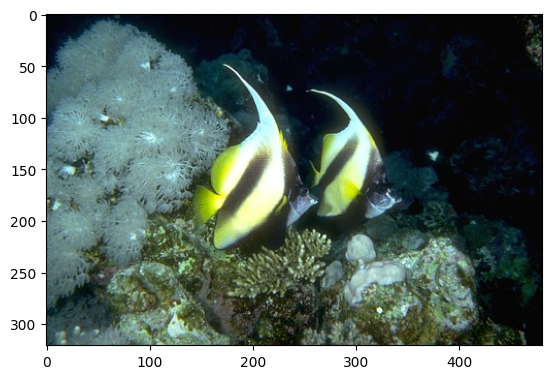

In [4]:
#gpu_device = jax.devices("gpu")[0]
cpu_device = jax.devices("cpu")[0]
key = jax.random.PRNGKey(0)


import cv2
import matplotlib.pyplot as plt
# open an image
img = cv2.imread("C:/Users/27118/Desktop/Imperial/abstraction-recovery/hierarchy/0066.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [5]:
import jax
import jax.numpy as jnp
import numpy as np

def salt_and_pepper(img, p, key):
    """
    img: jnp.array, shape = (H, W, 3)，值在 [0, 1]
    p  : noise ratio, 比如 0.3 表示 30% 像素被破坏（变成 0 或 1）
    """
    H, W, C = img.shape
    assert C == 3, "只考虑 RGB 三通道"

    key1, key2 = jax.random.split(key)

    # 每个“像素”一个标记，所以 shape = (H, W, 1)
    pepper_mask = jax.random.bernoulli(key1, p / 2, (H, W, 1))  # 变 0
    salt_mask   = jax.random.bernoulli(key2, p / 2, (H, W, 1))  # 变 1

    pepper_mask = pepper_mask.astype(img.dtype)
    salt_mask   = salt_mask.astype(img.dtype)

    # 先清零 pepper 的像素，再把 salt 的像素加成 1
    noisy = img * (1.0 - pepper_mask)
    noisy = noisy + salt_mask

    noisy = jnp.clip(noisy, 0.0, 1.0)
    return noisy


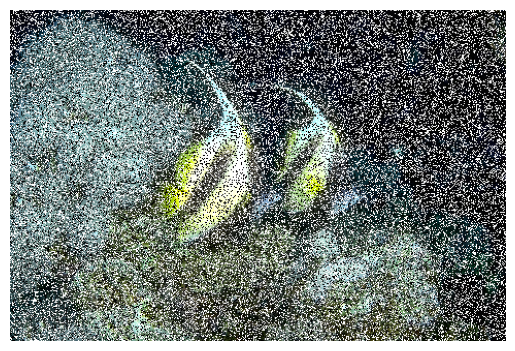

In [6]:
img = img / 255.0
img = img.astype(np.float32)
# img = cv2.resize(img, (12, 20))
# img = np.mean(img, axis=-1, keepdims=True)
# add salt and pepper noise
# 3. random key
key = jax.random.PRNGKey(0)

# 4. add salt & pepper noise
img = salt_and_pepper(img, p=0.5, key=key)

# 5. show（matplotlib wants numpy）
img = np.array(img)

plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
H, W, D = img.shape

N = H * W
Ni_v = 6
vars, prior_facs, between_facs = build_2D(img)

for i in range(1):
    tic = time.time()
    vars, vtof_msgs, linpoints = update_variable(vars)
    energy = 0
    for f, w, facs in zip([h_fn, h2_fn], [l2, l2], [prior_facs, between_facs]):
        facs, vars = update_factor(facs, vars, vtof_msgs, linpoints, f, w)
    # plt.draw()
    if i % 1 == 0:
        img = jax.jit(jax.vmap(lambda x: x.mu()))(vars.belief)
        plt.imshow(img.reshape(H, W, D))
        # plt.savefig(f"img_{i}.png")
        plt.pause(0.001)
        plt.cla()

    tok = time.time()
    print("iter", tok - tic, 1 / (tok - tic), "fps")

ValueError: not enough values to unpack (expected 3, got 2)